# Read in files

In [9]:
import sys
sys.path.append('eucalc_directory')
import eucalc as ec
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from numpy import genfromtxt
from sklearn.decomposition import PCA

# Path to the folder containing the CSV files
datafolder = "Segmentation_masks_Ben/Old_vs_Young"

all_files = os.listdir(datafolder)

# Get all CSV filenames in the folder
names = [file for file in all_files if file.lower().endswith(('.tif', '.tiff'))]


# Split names into K8 and K14 groups
names_k8 = [nm for nm in names if 'K8' in nm]
names_k14 = [nm for nm in names if 'K14' in nm]

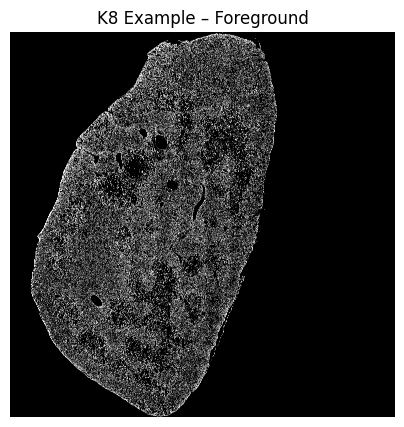

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
def segment_to_square(filename, title=None, margin=10, threshold=0):
    """
    Load an image, find the bounding box of all pixels > threshold,
    expand by `margin` pixels on each side, pad into a centered square,
    then plot and return the cropped PIL image.
    """
    # Load
    path = os.path.join("Segmentation_masks_Ben/Old_vs_Young", filename)
    img = Image.open(path)
    arr = np.array(img)

    # Build mask of “foreground” pixels
    if arr.ndim == 3:
        # if RGB/RGBA, just check ANY channel > threshold
        mask = np.any(arr[..., :3] > threshold, axis=2)
    else:
        mask = arr > threshold

    if not mask.any():
        raise ValueError(f"No pixels found above threshold {threshold}!")

    # Tight bbox
    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()

    # Expand by margin, clamped
    y0 = max(y0 - margin, 0)
    x0 = max(x0 - margin, 0)
    y1 = min(y1 + margin, arr.shape[0] - 1)
    x1 = min(x1 + margin, arr.shape[1] - 1)

    # Square side
    h, w = y1 - y0 + 1, x1 - x0 + 1
    side = max(h, w)

    # Center the square
    cy, cx = y0 + h//2, x0 + w//2
    y0_sq = max(cy - side//2, 0)
    x0_sq = max(cx - side//2, 0)
    y1_sq = min(y0_sq + side, arr.shape[0])
    x1_sq = min(x0_sq + side, arr.shape[1])

    # Crop
    cropped = arr[y0_sq:y1_sq, x0_sq:x1_sq]
    cropped_img = Image.fromarray(cropped)

    # Plot
    plt.figure(figsize=(5,5))
    if cropped.ndim == 2:
        plt.imshow(cropped, cmap="gray")
    else:
        plt.imshow(cropped)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

    return cropped_img

# Try it with threshold=0 (all non-zero pixels)
cropped_img = segment_to_square(names_k8[2], title="K8 Example – Foreground", margin=10, threshold=0)


# Paritition images or load parititioned images

In [ ]:
import os
from glob import glob
import numpy as np
from PIL import Image

input_dir       = "Segmentation_masks_Ben/Old_vs_Young"
output_dir      = "subimages_200x200_tiff"
patch_w,patch_h = 200, 200
min_pixels      = 2000
threshold       = 0      # pixels > 0 count as "foreground"

# — PREP OUTPUT FOLDER —
os.makedirs(output_dir, exist_ok=True)

# — HELPER TO LOAD EXISTING TIFF PATCHES —
def load_existing_patches():
    files = sorted(glob(os.path.join(output_dir, "*.tif")))
    patches = []
    patch_names = []
    for fp in files:
        patches.append(Image.open(fp))
        patch_names.append(os.path.basename(fp))
    return patches, patch_names

# — MAIN —
if glob(os.path.join(output_dir, "*.tif")):
    # Load already-processed patches and their filenames
    patches, patch_names = load_existing_patches()
else:
    patches = []
    patch_names = []
    for fname in names_k8:
        # load original image
        path = os.path.join(input_dir, fname)
        arr  = np.array(Image.open(path))
        H, W = arr.shape[:2]
        nrows, ncols = H // patch_h, W // patch_w
        base = os.path.splitext(fname)[0]

        for row in range(nrows):
            for col in range(ncols):
                y0, x0 = row * patch_h, col * patch_w
                tile = arr[y0:y0+patch_h, x0:x0+patch_w]

                # count "foreground" pixels
                fg = np.count_nonzero(tile > threshold)
                if fg >= min_pixels:
                    # bottom-to-top row index and left-to-right col index
                    rowIdx = (nrows - 1) - row
                    colIdx = col
                    outname = f"{base}_r{rowIdx}_c{colIdx}.tif"
                    outpath = os.path.join(output_dir, outname)
                    Image.fromarray(tile).save(outpath, format='TIFF')
                    patches.append(Image.fromarray(tile))
                    patch_names.append(outname)

# Now you have:
#   - patches: list of PIL.Image objects
#   - patch_names: list of their corresponding filenames
print(f"Loaded {len(patches)} patches from '{output_dir}'")


Loaded 10161 patches from 'subimages_200x200_tiff'


# Analysis with segmented quadrants

In [ ]:
old_k8_tiles = [patch for patch, name in zip(patches, patch_names) if 'O'== name[0]]
young_k8_tiles = [patch for patch, name in zip(patches, patch_names) if 'Y'== name[0]]
old_k8_names  = [name  for name in patch_names if name.startswith('O')]
young_k8_names = [name  for name in patch_names if name.startswith('Y')]
print(f"Old K8 tiles: {len(old_k8_tiles)}, Young K8 tiles: {len(young_k8_tiles)}")

Old K8 tiles: 5262, Young K8 tiles: 4899


## Set up statistical testing

In [16]:
import ot
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

def wasserstein_distance(empirical1, empirical2, p=2, delta_x=1.0):
    cost_matrix = cdist(empirical1, empirical2, metric='minkowski', p=p) * (delta_x ** (1.0 / p))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    avg_cost_p = np.mean(cost_matrix[row_ind, col_ind] ** p)
    return avg_cost_p ** (1.0 / p)

def monte_carlo_test(test_measure, sampled_measures, p=2, delta_x=1.0):
    all_measures = [test_measure] + sampled_measures
    N = len(all_measures)
    measures_weights = [np.ones(m.shape[0]) / m.shape[0] for m in all_measures]
    weights_measure = np.ones(N) / N
    k = all_measures[0].shape[0]
    d = all_measures[0].shape[1]
    D = np.zeros((N, N))
    for i in range(N):
        for j in range(i + 1, N):
            D[i, j] = D[j, i] = wasserstein_distance(all_measures[i], all_measures[j], p=p, delta_x=delta_x)
    medoid_idx = np.argmin(D.sum(axis=1))
    X_init = all_measures[medoid_idx].copy()
    b_init = np.ones(k) / k
    mu = ot.lp.free_support_barycenter(
        all_measures,
        measures_weights,
        X_init,
        b_init,
        weights=weights_measure,
        numItermax=1000,
        stopThr=1e-6,
        verbose=False
    )
    
    S0 = wasserstein_distance(test_measure, mu, p=p, delta_x=delta_x)
    Sis = [wasserstein_distance(m, mu, p=p, delta_x=delta_x) for m in sampled_measures]
    p_val = np.mean([S0 >= s for s in Sis])
    return S0, Sis, p_val

## Set up topological descriptor

In [17]:
import os
import tifffile as tiff
import eucalc as ec
import matplotlib.colors as mcolors
from PIL import Image
class SampEuler:
    def __init__(self,  img, k=20, xinterval=(-1., 1.), xpoints=100):
        self.xinterval = xinterval
        self.xpoints = xpoints
        self.image = self.compute(img, k, xinterval, xpoints)
    def compute(self, img, k, xinterval, xpoints):
        cplx = ec.EmbeddedComplex(img)
        cplx.preproc_ect()
        thetas = np.random.uniform(0, 2 * np.pi, k + 1)
        ect1 = np.empty((k, xpoints), dtype=float)
        for i in range(k):
            theta = thetas[i]
            direction = np.array((np.sin(theta), np.cos(theta)))
            ect_dir = cplx.compute_euler_characteristic_transform(direction)
            T = np.linspace(xinterval[0], xinterval[1], xpoints)
            ect1[i] = [ect_dir.evaluate(t) for t in T]
        return ect1


def compute_SampEuler(patches, k=480, xinterval=(-1.5, 1.5), xpoints=300):
    SampEulers = []
    
    for patch in patches: 
        img_array = np.array(patch)
        # Now, compute the ECT image using the new array
        ect = SampEuler(img_array, k, xinterval, xpoints)
        exim = ect.compute(img_array, k, xinterval, xpoints)
        SampEulers.append(exim)

    return SampEulers

## Computation for K8

In [18]:
sampeulers_old = compute_SampEuler(old_k8_tiles, k=480, xinterval=(-1.5,1.5), xpoints=9000)
sampeulers_young = compute_SampEuler(young_k8_tiles, k=480, xinterval=(-1.5,1.5), xpoints=9000)
delta_x = 3.0/9000.0
old_p_values = []
for i in range(len(sampeulers_old)):
    _, _, p_val = monte_carlo_test(sampeulers_old[i], sampeulers_young, p=2, delta_x=delta_x)
    old_p_values.append(p_val)





: 